In [1]:
import pandas as pd
import unicodedata
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import mord   # library for ordinal regression

In [2]:
def canonicalize_name(s: str) -> str:
    if pd.isna(s):
        return s
    # strip trailing position like " ... C" or " ... F" or " ... G"
    s = re.sub(r"\s+[CFG]$", "", s.strip())
    # normalise accents to plain ascii (Jokić -> Jokic)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    # collapse spaces and lowercase
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

# --- load player data ---
player = pd.read_csv("NBA_PLAYER_DATASET.csv")

# make a canonical name for matching
player["name_canon"] = player["Name"].apply(canonicalize_name)

# --- load & tidy all-nba ---
all_nba_raw = pd.read_csv("all_nba.csv")

# melt wide (C,F,F.1,G,G.1) to tidy rows
value_cols = [c for c in ["C","F.1","F.2","G.1","G.2"] if c in all_nba_raw.columns]
all_nba_tidy = all_nba_raw.melt(
    id_vars=["Season","Tm"],
    value_vars=value_cols,
    var_name="Position",
    value_name="Name"
).dropna(subset=["Name"])

# canonical name for matching
all_nba_tidy["name_canon"] = all_nba_tidy["Name"].apply(canonicalize_name)
all_nba_tidy = all_nba_tidy.rename(columns={"Tm":"All_NBA_Team"})

# --- merge on season + canonical name ---
merged = player.merge(
    all_nba_tidy[["Season","name_canon","All_NBA_Team"]],
    left_on=["SEASON_ID","name_canon"],
    right_on=["Season","name_canon"],
    how="left"
)

# keep one season column and fill label
merged = merged.drop(columns=["Season"])
merged["All_NBA_Team"] = merged["All_NBA_Team"].fillna("None")

# # (optional) check a sample
# print(merged[["SEASON_ID","Name","TEAM_ABBREVIATION","PTS","All_NBA_Team"]].head())
merged.to_csv("merged_nba_dataset.csv", index=False)


In [3]:
# Optional: tidy up helper column if it's still around
if "name_canon" in merged.columns:
    merged = merged.drop(columns=["name_canon"])

# Create an ordinal label from All_NBA_Team
allnba_to_ordinal = {"None": 0, "3rd": 1, "2nd": 2, "1st": 3}

# If All_NBA_Team has any unexpected values, they’ll become <NA> then we fill with 0
merged["All_NBA_Label"] = (
    merged["All_NBA_Team"]
    .map(allnba_to_ordinal)
    .fillna(0)
    .astype("Int64")   # pandas nullable integer dtype
)

# Quick sanity check
print(merged[["Name","SEASON_ID","All_NBA_Team","All_NBA_Label"]].head())
print("Unique label values:", sorted(merged["All_NBA_Label"].dropna().unique()))
merged.to_csv("merged_nba_dataset.csv", index=False)


             Name SEASON_ID All_NBA_Team  All_NBA_Label
0  Alaa Abdelnaby   1990-91         None              0
1  Alaa Abdelnaby   1991-92         None              0
2  Alaa Abdelnaby   1992-93         None              0
3  Alaa Abdelnaby   1992-93         None              0
4  Alaa Abdelnaby   1992-93         None              0
Unique label values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


Now calculate per game statistics, and add to set data:

In [4]:
# Choose the working df (uncomment the one you’re using)
df = merged
# df = player_data_set

# Protect against divide-by-zero for GP
gp_safe = df["GP"].replace({0: pd.NA})

# Add per-game columns
df["PPG"]  = df["PTS"] / gp_safe          # Points per game
df["APG"]  = df["AST"] / gp_safe          # Assists per game
df["RPG"]  = df["REB"] / gp_safe          # Rebounds per game
df["BPG"]  = df["BLK"] / gp_safe          # Blocks per game
df["SPG"]  = df["STL"] / gp_safe          # Steals per game
df["TOPG"] = df["TOV"] / gp_safe          # Turnovers per game
df["MPG"]  = df["MIN"] / gp_safe          # (optional) Minutes per game

# (Optional) round for display—keep full precision for modeling if you prefer
display_cols = ["Name","SEASON_ID","GP","MPG","PPG","APG","RPG","BPG","SPG","TOPG"]
print(df[display_cols].head(10).round(2))

# Save updated dataset (overwrites existing)
df.to_csv("merged_nba_dataset.csv", index=False)
print("Updated dataset with per-game stats saved to merged_nba_dataset.csv")

              Name SEASON_ID  GP    MPG    PPG   APG    RPG   BPG   SPG  TOPG
0   Alaa Abdelnaby   1990-91  43   6.74   3.14  0.28   2.07  0.28  0.09  0.51
1   Alaa Abdelnaby   1991-92  71  13.15   6.08  0.42   3.66  0.23  0.35  0.93
2   Alaa Abdelnaby   1992-93  12  13.25   5.33  0.83   3.08  0.33  0.50  1.08
3   Alaa Abdelnaby   1992-93  63  18.29   8.16  0.27   4.76  0.35  0.30  1.33
4   Alaa Abdelnaby   1992-93  75  17.48   7.71  0.36   4.49  0.35  0.33  1.29
5   Alaa Abdelnaby   1993-94  13  12.23   4.92  0.23   3.54  0.23  0.15  1.31
6   Alaa Abdelnaby   1994-95  51   9.33   4.98  0.25   2.08  0.24  0.29  0.78
7   Alaa Abdelnaby   1994-95   3  10.00   0.67  0.00   2.67  0.00  0.00  1.67
8   Alaa Abdelnaby   1994-95  54   9.37   4.74  0.24   2.11  0.22  0.28  0.83
9  Zaid Abdul-Aziz   1968-69  29  28.86  11.03  1.14  13.03   NaN   NaN   NaN
Updated dataset with per-game stats saved to merged_nba_dataset.csv


Now we have a merged, cleaned dataset. We have some basic player statistics per season, and added on if the player for that season made an All-Nba Team. If so, if ranks which All-Nba team they made. 

In addition, the All-NBA teams are assigned a value from 1-3 such that ordinal regression (SVM) can occur. 

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# ---- Load and prepare data (same as before)
df = pd.read_csv("merged_nba_dataset.csv")
if "All_NBA_Label" not in df.columns:
    mapping = {"None": 0, "3rd": 1, "2nd": 2, "1st": 3}
    df["All_NBA_Label"] = df["All_NBA_Team"].map(mapping).fillna(0).astype(int)
if "PPG" not in df.columns:
    df["PPG"] = df["PTS"] / df["GP"].replace({0: np.nan})
df["_is_tot"] = (df["TEAM_ABBREVIATION"] == "TOT").astype(int)
df = df.sort_values(["Name", "SEASON_ID", "_is_tot"], ascending=[True, True, False])
df = df.drop_duplicates(subset=["Name", "SEASON_ID"], keep="first").drop(columns=["_is_tot"])
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df80 = df[df["_season_start"] >= 1980].copy()
df80 = df80.dropna(subset=["PPG"])
df80 = df80[df80["All_NBA_Label"].isin([0,1,2,3])]

X = df80[["PPG"]].values
y = df80["All_NBA_Label"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---- Ordinal SVM via thresholds, testing different C values
C_values = [0.01, 0.1, 1, 5, 10, 50, 100]
results = []

for C_val in C_values:
    thresholds = [1, 2, 3]
    svms = []
    for k in thresholds:
        y_bin = (y_train >= k).astype(int)
        clf = LinearSVC(C=C_val, class_weight="balanced", max_iter=5000, random_state=42)
        clf.fit(X_train, y_bin)
        svms.append(clf)

    def predict_ordinal(X_mat):
        preds = np.zeros(X_mat.shape[0], dtype=int)
        for clf in svms:
            preds += clf.predict(X_mat)
        return preds

    y_pred = predict_ordinal(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    results.append((C_val, acc, f1))

    print(f"\nC = {C_val}")
    print("Accuracy:", round(acc, 3))
    print("Macro F1:", round(f1, 3))
    print(confusion_matrix(y_test, y_pred))

# ---- Summary table
results_df = pd.DataFrame(results, columns=["C", "Accuracy", "Macro_F1"])
print("\nSummary of performance by C:")
print(results_df)



C = 0.01
Accuracy: 0.875
Macro F1: 0.289
[[3315   32   61  336]
 [   3    3    0   16]
 [   2    0    0   24]
 [   2    0    0   24]]

C = 0.1
Accuracy: 0.875
Macro F1: 0.278
[[3315   43   56  330]
 [   4    2    0   16]
 [   2    0    0   24]
 [   2    0    0   24]]

C = 1
Accuracy: 0.875
Macro F1: 0.271
[[3315   43   57  329]
 [   5    1    0   16]
 [   2    0    0   24]
 [   2    0    0   24]]

C = 5
Accuracy: 0.875
Macro F1: 0.271
[[3315   43   57  329]
 [   5    1    0   16]
 [   2    0    0   24]
 [   2    0    0   24]]

C = 10
Accuracy: 0.875
Macro F1: 0.271
[[3315   43   57  329]
 [   5    1    0   16]
 [   2    0    0   24]
 [   2    0    0   24]]

C = 50
Accuracy: 0.875
Macro F1: 0.271
[[3315   43   57  329]
 [   5    1    0   16]
 [   2    0    0   24]
 [   2    0    0   24]]

C = 100
Accuracy: 0.875
Macro F1: 0.271
[[3315   43   57  329]
 [   5    1    0   16]
 [   2    0    0   24]
 [   2    0    0   24]]

Summary of performance by C:
        C  Accuracy  Macro_F1
0    0.

Now, add PPG, APG and RPG to see if it improves

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# ---- Load and prepare data
df = pd.read_csv("merged_nba_dataset.csv")

# Ensure label
if "All_NBA_Label" not in df.columns:
    mapping = {"None": 0, "3rd": 1, "2nd": 2, "1st": 3}
    df["All_NBA_Label"] = df["All_NBA_Team"].map(mapping).fillna(0).astype(int)

# Ensure per-game stats exist
gp_safe = df["GP"].replace({0: np.nan})
if "PPG" not in df.columns:
    df["PPG"] = df["PTS"] / gp_safe
if "APG" not in df.columns:
    df["APG"] = df["AST"] / gp_safe
if "RPG" not in df.columns:
    df["RPG"] = df["REB"] / gp_safe

# Prefer season totals (TOT) when available (one row per player-season)
df["_is_tot"] = (df["TEAM_ABBREVIATION"] == "TOT").astype(int)
df = df.sort_values(["Name", "SEASON_ID", "_is_tot"], ascending=[True, True, False])
df = df.drop_duplicates(subset=["Name", "SEASON_ID"], keep="first").drop(columns=["_is_tot"])

# Filter seasons: 1980+
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df = df[df["_season_start"] >= 1980].copy()

# Keep rows with valid features & labels
df = df.dropna(subset=["PPG","APG","RPG"])
df = df[df["All_NBA_Label"].isin([0,1,2,3])]

# Features & target (PPG, APG, RPG)
feature_cols = ["PPG", "APG", "RPG"]
X = df[feature_cols].to_numpy(dtype=float)
y = df["All_NBA_Label"].astype(int).to_numpy()

# Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---- Ordinal SVM via cumulative thresholds, sweep over C
C_values = [0.0001,0.001,0.01, 0.1, 1, 5, 10, 50, 100]
results = []

for C_val in C_values:
    svms = []
    for k in [1, 2, 3]:
        y_bin = (y_train >= k).astype(int)
        clf = LinearSVC(
            C=C_val,
            class_weight="balanced",   # important for imbalance
            dual=False,                # faster/more stable for n_samples > n_features
            max_iter=10000,
            random_state=42
        )
        clf.fit(X_train, y_bin)
        svms.append(clf)

    def predict_ordinal(Xm):
        preds = np.zeros(Xm.shape[0], dtype=int)
        for clf in svms:
            preds += clf.predict(Xm)   # adds 0/1 per threshold
        return preds                   # in {0,1,2,3}

    y_pred = predict_ordinal(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    results.append((C_val, acc, macro_f1))

    print(f"\nC = {C_val}")
    print("Accuracy:", round(acc, 3))
    print("Macro F1:", round(macro_f1, 3))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    # Optional: print per-class report
    # print(classification_report(y_test, y_pred, digits=3))

# Summary table
results_df = pd.DataFrame(results, columns=["C", "Accuracy", "Macro_F1"])
print("\nSummary of performance by C:")
print(results_df)



C = 0.0001
Accuracy: 0.82
Macro F1: 0.246
Confusion matrix:
 [[3106   35   45  558]
 [   0    0    0   22]
 [   0    0    0   26]
 [   0    0    0   26]]

C = 0.001
Accuracy: 0.881
Macro F1: 0.282
Confusion matrix:
 [[3335   55   40  314]
 [   1    0    2   19]
 [   1    0    2   23]
 [   0    0    0   26]]

C = 0.01
Accuracy: 0.903
Macro F1: 0.304
Confusion matrix:
 [[3417   40   61  226]
 [   2    1    5   14]
 [   1    1    3   21]
 [   0    0    0   26]]

C = 0.1
Accuracy: 0.905
Macro F1: 0.314
Confusion matrix:
 [[3425   54   55  210]
 [   2    2    4   14]
 [   1    1    4   20]
 [   0    0    2   24]]

C = 1
Accuracy: 0.905
Macro F1: 0.315
Confusion matrix:
 [[3426   56   53  209]
 [   2    2    4   14]
 [   1    1    4   20]
 [   0    0    2   24]]

C = 5
Accuracy: 0.905
Macro F1: 0.315
Confusion matrix:
 [[3426   57   53  208]
 [   2    2    4   14]
 [   1    1    4   20]
 [   0    0    2   24]]

C = 10
Accuracy: 0.905
Macro F1: 0.315
Confusion matrix:
 [[3426   57   53  208]

Let's add games played as an input variable

In [11]:
# =========================================================
# ORDINAL SVM (using existing per-game stats)
# =========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 1. Load dataset
df = pd.read_csv("merged_nba_dataset.csv")

# 2. Keep seasons from 1980 onwards
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df = df[df["_season_start"] >= 1980]

# 3. Select features and target
feature_cols = ["PPG", "APG", "RPG", "GP"]
X = df[feature_cols].to_numpy()
y = df["All_NBA_Label"].astype(int).to_numpy()

# 4. Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 5. Sweep over C values
C_values = [0.01, 0.1, 1, 10, 100]
results = []

for C in C_values:
    thresholds = [1, 2, 3]
    svms = []

    # Train three binary SVMs (y ≥ 1, 2, 3)
    for k in thresholds:
        y_bin = (y_train >= k).astype(int)
        clf = LinearSVC(C=C, class_weight="balanced", max_iter=5000, random_state=42)
        clf.fit(X_train, y_bin)
        svms.append(clf)

    # Predict ordinal labels
    preds = np.zeros(X_test.shape[0], dtype=int)
    for clf in svms:
        preds += clf.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average="macro")
    results.append((C, acc, macro_f1))

    print(f"\nC = {C}")
    print("Accuracy:", round(acc,3))
    print("Macro F1:", round(macro_f1,3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

# 6. Summary table
results_df = pd.DataFrame(results, columns=["C", "Accuracy", "Macro_F1"])
print("\nSummary of results:")
print(results_df)



C = 0.01
Accuracy: 0.905
Macro F1: 0.272
Confusion Matrix:
 [[4233   54   51  293]
 [   4    0    2   16]
 [   1    0    0   26]
 [   0    0    0   26]]

C = 0.1
Accuracy: 0.909
Macro F1: 0.287
Confusion Matrix:
 [[4250   60   54  267]
 [   4    2    1   15]
 [   1    0    0   26]
 [   0    0    0   26]]

C = 1
Accuracy: 0.91
Macro F1: 0.294
Confusion Matrix:
 [[4255   56   56  264]
 [   4    2    3   13]
 [   1    0    1   25]
 [   0    0    0   26]]

C = 10
Accuracy: 0.91
Macro F1: 0.294
Confusion Matrix:
 [[4255   56   56  264]
 [   4    2    3   13]
 [   1    0    1   25]
 [   0    0    0   26]]

C = 100
Accuracy: 0.91
Macro F1: 0.294
Confusion Matrix:
 [[4255   57   55  264]
 [   4    2    3   13]
 [   1    0    1   25]
 [   0    0    0   26]]

Summary of results:
        C  Accuracy  Macro_F1
0    0.01  0.905015  0.272232
1    0.10  0.909052  0.287156
2    1.00  0.910327  0.294257
3   10.00  0.910327  0.294257
4  100.00  0.910327  0.294170


Let's manipulate the dataset and add rankings for ppg, apg and rpg

In [15]:
# =========================================================
# ADD RANK COLUMNS (PPG, APG, RPG) PER SEASON
# =========================================================

import pandas as pd

# 1. Load dataset
df = pd.read_csv("merged_nba_dataset.csv")

# 2. Keep only valid seasons
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)

# 3. Rank players within each season by PPG, APG, and RPG (higher = better)
df["PPG_Rank"] = df.groupby("SEASON_ID")["PPG"].rank(ascending=False, method="dense")
df["APG_Rank"] = df.groupby("SEASON_ID")["APG"].rank(ascending=False, method="dense")
df["RPG_Rank"] = df.groupby("SEASON_ID")["RPG"].rank(ascending=False, method="dense")

# 4. Replace NaN ranks with 0 and convert to integers
df[["PPG_Rank", "APG_Rank", "RPG_Rank"]] = df[["PPG_Rank", "APG_Rank", "RPG_Rank"]].fillna(0).astype(int)

df = df.round(2)

# 5. Save to new CSV
df.to_csv("nba_dataset_ranking.csv", index=False)

print("✅ New file created: nba_dataset_ranking.csv")
print("Columns added: PPG_Rank, APG_Rank, RPG_Rank")


✅ New file created: nba_dataset_ranking.csv
Columns added: PPG_Rank, APG_Rank, RPG_Rank


Now guess All-nba Based off rankings rather than raw nba statistics

In [17]:
# =========================================================
# ORDINAL SVM using PPG_Rank, APG_Rank, RPG_Rank, GP
# =========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 1. Load ranked dataset
df = pd.read_csv("nba_dataset_ranking.csv")

# 2. Keep seasons from 1980 onward
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df = df[df["_season_start"] >= 1980]

# 3. Select features (ranking + GP) and target
feature_cols = ["PPG_Rank", "APG_Rank", "RPG_Rank", "GP"]
X = df[feature_cols].to_numpy()
y = df["All_NBA_Label"].astype(int).to_numpy()

# 4. Train/test split and scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 5. Sweep over C values
C_values = [0.01, 0.1, 1, 10, 100]
results = []

for C in C_values:
    thresholds = [1, 2, 3]
    svms = []

    # Train binary SVMs for thresholds (y >= 1, 2, 3)
    for k in thresholds:
        y_bin = (y_train >= k).astype(int)
        clf = LinearSVC(C=C, class_weight="balanced", max_iter=5000, random_state=42)
        clf.fit(X_train, y_bin)
        svms.append(clf)

    # Predict ordinal labels
    preds = np.zeros(X_test.shape[0], dtype=int)
    for clf in svms:
        preds += clf.predict(X_test)

    # Evaluate performance
    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average="macro")
    results.append((C, acc, macro_f1))

    print(f"\nC = {C}")
    print("Accuracy:", round(acc,3))
    print("Macro F1:", round(macro_f1,3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

# 6. Summary table
results_df = pd.DataFrame(results, columns=["C","Accuracy","Macro_F1"])
print("\nSummary of Results:")
print(results_df)



C = 0.01
Accuracy: 0.86
Macro F1: 0.265
Confusion Matrix:
 [[4018   53  117  443]
 [   2    1    2   17]
 [   1    0    1   25]
 [   0    0    1   25]]

C = 0.1
Accuracy: 0.87
Macro F1: 0.273
Confusion Matrix:
 [[4068   62  141  360]
 [   2    2    2   16]
 [   2    0    0   25]
 [   1    0    0   25]]

C = 1
Accuracy: 0.871
Macro F1: 0.273
Confusion Matrix:
 [[4073   67  141  350]
 [   2    2    2   16]
 [   2    0    0   25]
 [   1    0    0   25]]

C = 10
Accuracy: 0.871
Macro F1: 0.273
Confusion Matrix:
 [[4073   67  141  350]
 [   2    2    2   16]
 [   2    0    0   25]
 [   1    0    0   25]]

C = 100
Accuracy: 0.871
Macro F1: 0.273
Confusion Matrix:
 [[4073   67  141  350]
 [   2    2    2   16]
 [   2    0    0   25]
 [   1    0    0   25]]

Summary of Results:
        C  Accuracy  Macro_F1
0    0.01  0.859541  0.265479
1    0.10  0.870166  0.272968
2    1.00  0.871228  0.273108
3   10.00  0.871228  0.273108
4  100.00  0.871228  0.273108


DECISION TREE

In [33]:
# =========================================================
# DECISION TREE using PPG_Rank, APG_Rank, RPG_Rank, GP
# =========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 1. Load dataset
df = pd.read_csv("nba_dataset_ranking.csv")

# 2. Keep seasons from 1980 onward
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df = df[df["_season_start"] >= 1980]

# 3. Select features and target
feature_cols = ["PPG_Rank", "APG_Rank", "RPG_Rank", "GP"]
X = df[feature_cols].to_numpy()
y = df["All_NBA_Label"].astype(int).to_numpy()

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. 

# UNSCALED
X_train = X_train
X_test  = X_test

# # Scale (optional for tree – included for consistency)
# # # scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test  = scaler.transform(X_test)

# 6. Sweep over different max_depth values
depth_values = [3, 5, 7, 9, 12,15,20]
results = []

for d in depth_values:
    tree = DecisionTreeClassifier(max_depth=d, class_weight="balanced", random_state=42)
    tree.fit(X_train, y_train)

    preds = tree.predict(X_test)
    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average="macro")
    results.append((d, acc, macro_f1))

    print(f"\nMax Depth = {d}")
    print("Accuracy:", round(acc,3))
    print("Macro F1:", round(macro_f1,3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

# 7. Summary table
results_df = pd.DataFrame(results, columns=["Max_Depth","Accuracy","Macro_F1"])
print("\nSummary of Results:")
print(results_df)



Max Depth = 3
Accuracy: 0.827
Macro F1: 0.336
Confusion Matrix:
 [[3860  724   18   29]
 [   1   18    3    0]
 [   0   21    2    4]
 [   0   13    2   11]]

Max Depth = 5
Accuracy: 0.913
Macro F1: 0.368
Confusion Matrix:
 [[4259  127  214   31]
 [   3    7   12    0]
 [   1    1   21    4]
 [   0    3   13   10]]

Max Depth = 7
Accuracy: 0.903
Macro F1: 0.387
Confusion Matrix:
 [[4211  113  285   22]
 [   4    7   11    0]
 [   1    2   21    3]
 [   0    4   10   12]]

Max Depth = 9
Accuracy: 0.924
Macro F1: 0.361
Confusion Matrix:
 [[4313  104  172   42]
 [   4    4   11    3]
 [   2    4   17    4]
 [   2    8    4   12]]

Max Depth = 12
Accuracy: 0.951
Macro F1: 0.385
Confusion Matrix:
 [[4447   62   87   35]
 [   7    6    8    1]
 [   8    3   15    1]
 [  10    5    3    8]]

Max Depth = 15
Accuracy: 0.962
Macro F1: 0.354
Confusion Matrix:
 [[4511   58   34   28]
 [  11    4    5    2]
 [  12    8    4    3]
 [  12    4    2    8]]

Max Depth = 20
Accuracy: 0.975
Macro F1: 0.

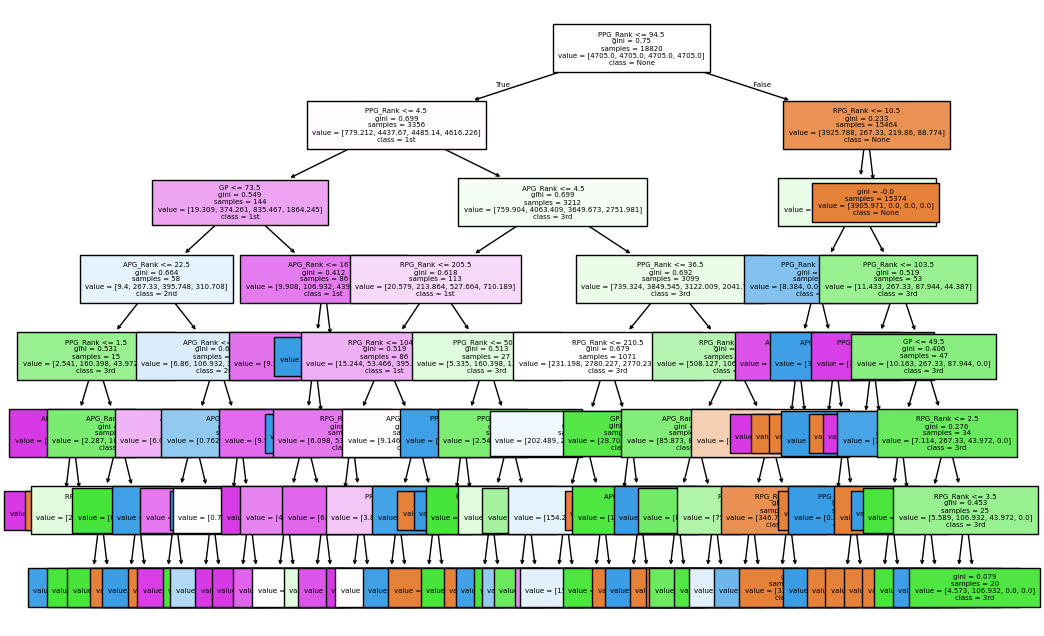

In [31]:
from sklearn import tree
import matplotlib.pyplot as plt

# Assume you’ve already trained the best model (for example, with depth=7)
model = DecisionTreeClassifier(max_depth=7, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

plt.figure(figsize=(12,8))
tree.plot_tree(model, 
               feature_names=feature_cols, 
               class_names=["None","3rd","2nd","1st"], 
               filled=True,
               fontsize=5)
plt.savefig("decision_tree_allnba.png", dpi=300, bbox_inches="tight")
plt.show()


NEURAL NETWORK:

In [34]:
# =========================================================
# NEURAL NETWORK (MLP) using ranked features
# =========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 1. Load dataset
df = pd.read_csv("nba_dataset_ranking.csv")

# 2. Keep data from 1980 onwards
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df = df[df["_season_start"] >= 1980]

# 3. Select ranked features and target
feature_cols = ["PPG_Rank", "APG_Rank", "RPG_Rank", "GP"]
X = df[feature_cols].to_numpy()
y = df["All_NBA_Label"].astype(int).to_numpy()

# 4. Train/test split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 5. Define and train the neural network
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),   # two hidden layers (can tweak)
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42,
    early_stopping=True
)

mlp.fit(X_train, y_train)

# 6. Evaluate
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\nNeural Network (Ranked Stats)")
print("Accuracy:", round(acc,3))
print("Macro F1:", round(macro_f1,3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Neural Network (Ranked Stats)
Accuracy: 0.984
Macro F1: 0.248
Confusion Matrix:
 [[4631    0    0    0]
 [  22    0    0    0]
 [  27    0    0    0]
 [  26    0    0    0]]


In [35]:
# =========================================================
# NEURAL NETWORK (MLP) using per-game statistics
# =========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 1. Load dataset
df = pd.read_csv("merged_nba_dataset.csv")

# 2. Keep data from 1980 onwards
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df = df[df["_season_start"] >= 1980]

# 3. Select features and target
feature_cols = ["PPG", "APG", "RPG", "GP"]
X = df[feature_cols].to_numpy()
y = df["All_NBA_Label"].astype(int).to_numpy()

# 4. Train/test split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 5. Define and train neural network
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42,
    early_stopping=True
)

mlp.fit(X_train, y_train)

# 6. Evaluate
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\nNeural Network (Per-Game Stats)")
print("Accuracy:", round(acc,3))
print("Macro F1:", round(macro_f1,3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Neural Network (Per-Game Stats)
Accuracy: 0.984
Macro F1: 0.248
Confusion Matrix:
 [[4631    0    0    0]
 [  22    0    0    0]
 [  27    0    0    0]
 [  26    0    0    0]]


Add weights:

In [38]:
# =========================================================
# NEURAL NETWORK (MLP) using ranked features + OVERSAMPLING
# =========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 1) Load dataset
df = pd.read_csv("nba_dataset_ranking.csv")

# 2) Keep data from 1980 onwards
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df = df[df["_season_start"] >= 1980]

# 3) Features (ranked) and target
feature_cols = ["PPG_Rank", "APG_Rank", "RPG_Rank", "GP"]
X = df[feature_cols].to_numpy(dtype=float)
y = df["All_NBA_Label"].astype(int).to_numpy()

# 4) Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 5) Oversample training set to balance classes (no external libs)
rng = np.random.default_rng(42)
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()

indices_balanced = []
for c in classes:
    idx_c = np.where(y_train == c)[0]
    # sample with replacement up to max_count
    sampled = rng.choice(idx_c, size=max_count, replace=True)
    indices_balanced.append(sampled)

indices_balanced = np.concatenate(indices_balanced)
rng.shuffle(indices_balanced)

X_train_bal = X_train[indices_balanced]
y_train_bal = y_train[indices_balanced]

print("Class counts before:", dict(zip(classes, counts)))
print("Class counts after:", dict(zip(*np.unique(y_train_bal, return_counts=True))))

# 6) Define and train the neural network
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42,
    early_stopping=True
)

mlp.fit(X_train_bal, y_train_bal)

# 7) Evaluate
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\nNeural Network (Ranked Stats + Oversampling)")
print("Accuracy:", round(acc, 3))
print("Macro F1:", round(macro_f1, 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))


Class counts before: {np.int64(0): np.int64(18519), np.int64(1): np.int64(88), np.int64(2): np.int64(107), np.int64(3): np.int64(106)}
Class counts after: {np.int64(0): np.int64(18519), np.int64(1): np.int64(18519), np.int64(2): np.int64(18519), np.int64(3): np.int64(18519)}

Neural Network (Ranked Stats + Oversampling)
Accuracy: 0.895
Macro F1: 0.34
Confusion Matrix:
 [[4179  261  105   86]
 [   3    8    8    3]
 [   1    8    8   10]
 [   0    8    0   18]]

Detailed Classification Report:

              precision    recall  f1-score   support

           0      0.999     0.902     0.948      4631
           1      0.028     0.364     0.052        22
           2      0.066     0.296     0.108        27
           3      0.154     0.692     0.252        26

    accuracy                          0.895      4706
   macro avg      0.312     0.564     0.340      4706
weighted avg      0.984     0.895     0.935      4706



In [39]:
# =========================================================
# NEURAL NETWORK (MLP) using per-game stats + OVERSAMPLING
# =========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 1) Load dataset (has PPG, APG, RPG, GP already)
df = pd.read_csv("merged_nba_dataset.csv")

# 2) Keep data from 1980 onwards
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df = df[df["_season_start"] >= 1980]

# 3) Features (per-game) and target
feature_cols = ["PPG", "APG", "RPG", "GP"]
X = df[feature_cols].to_numpy(dtype=float)
y = df["All_NBA_Label"].astype(int).to_numpy()

# 4) Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 5) Oversample training set to balance classes (no external libs)
rng = np.random.default_rng(42)
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()

indices_balanced = []
for c in classes:
    idx_c = np.where(y_train == c)[0]
    sampled = rng.choice(idx_c, size=max_count, replace=True)  # sample with replacement
    indices_balanced.append(sampled)

indices_balanced = np.concatenate(indices_balanced)
rng.shuffle(indices_balanced)

X_train_bal = X_train[indices_balanced]
y_train_bal = y_train[indices_balanced]

print("Class counts before:", dict(zip(classes, counts)))
print("Class counts after:", dict(zip(*np.unique(y_train_bal, return_counts=True))))

# 6) Define and train the neural network (simple MLP like in class)
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42,
    early_stopping=True
)
mlp.fit(X_train_bal, y_train_bal)

# 7) Evaluate
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\nNeural Network (Per-Game Stats + Oversampling)")
print("Accuracy:", round(acc, 3))
print("Macro F1:", round(macro_f1, 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))


Class counts before: {np.int64(0): np.int64(18519), np.int64(1): np.int64(88), np.int64(2): np.int64(107), np.int64(3): np.int64(106)}
Class counts after: {np.int64(0): np.int64(18519), np.int64(1): np.int64(18519), np.int64(2): np.int64(18519), np.int64(3): np.int64(18519)}

Neural Network (Per-Game Stats + Oversampling)
Accuracy: 0.912
Macro F1: 0.378
Confusion Matrix:
 [[4250  218  106   57]
 [   2   12    8    0]
 [   2    6   14    5]
 [   1    3    7   15]]

Detailed Classification Report:

              precision    recall  f1-score   support

           0      0.999     0.918     0.957      4631
           1      0.050     0.545     0.092        22
           2      0.104     0.519     0.173        27
           3      0.195     0.577     0.291        26

    accuracy                          0.912      4706
   macro avg      0.337     0.640     0.378      4706
weighted avg      0.985     0.912     0.944      4706



In [40]:
# =========================================================
# NEURAL NETWORK (MLP) using per-game + ranked features + OVERSAMPLING
# =========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 1) Load dataset (ranked dataset already includes both per-game and rank stats)
df = pd.read_csv("nba_dataset_ranking.csv")

# 2) Keep data from 1980 onwards
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df = df[df["_season_start"] >= 1980]

# 3) Combine per-game and ranked features
feature_cols = [
    "PPG", "APG", "RPG", "GP",       # per-game stats
    "PPG_Rank", "APG_Rank", "RPG_Rank"  # ranked stats
]
X = df[feature_cols].to_numpy(dtype=float)
y = df["All_NBA_Label"].astype(int).to_numpy()

# 4) Train/test split and scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 5) Oversample training set (simple custom oversampling)
rng = np.random.default_rng(42)
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()

indices_balanced = []
for c in classes:
    idx_c = np.where(y_train == c)[0]
    sampled = rng.choice(idx_c, size=max_count, replace=True)
    indices_balanced.append(sampled)

indices_balanced = np.concatenate(indices_balanced)
rng.shuffle(indices_balanced)

X_train_bal = X_train[indices_balanced]
y_train_bal = y_train[indices_balanced]

print("Class counts before:", dict(zip(classes, counts)))
print("Class counts after:", dict(zip(*np.unique(y_train_bal, return_counts=True))))

# 6) Define and train neural network
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42,
    early_stopping=True
)
mlp.fit(X_train_bal, y_train_bal)

# 7) Evaluate
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\nNeural Network (Per-Game + Ranked Stats + Oversampling)")
print("Accuracy:", round(acc, 3))
print("Macro F1:", round(macro_f1, 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))


Class counts before: {np.int64(0): np.int64(18519), np.int64(1): np.int64(88), np.int64(2): np.int64(107), np.int64(3): np.int64(106)}
Class counts after: {np.int64(0): np.int64(18519), np.int64(1): np.int64(18519), np.int64(2): np.int64(18519), np.int64(3): np.int64(18519)}

Neural Network (Per-Game + Ranked Stats + Oversampling)
Accuracy: 0.924
Macro F1: 0.372
Confusion Matrix:
 [[4313  136  136   46]
 [   3   10    8    1]
 [   2    4   13    8]
 [   0    7    6   13]]

Detailed Classification Report:

              precision    recall  f1-score   support

           0      0.999     0.931     0.964      4631
           1      0.064     0.455     0.112        22
           2      0.080     0.481     0.137        27
           3      0.191     0.500     0.277        26

    accuracy                          0.924      4706
   macro avg      0.333     0.592     0.372      4706
weighted avg      0.985     0.924     0.951      4706



In [41]:
# =========================================================
# NEURAL NETWORK (MLP) — richer per-game + efficiency stats
# =========================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 1) Load dataset (per-game stats already present)
df = pd.read_csv("merged_nba_dataset.csv")

# 2) Keep data from 1980 onwards
df["_season_start"] = df["SEASON_ID"].astype(str).str[:4].astype(int)
df = df[df["_season_start"] >= 1980]

# 3) Feature set (no ranks): per-game + availability + efficiency
feature_cols = [
    "PPG","APG","RPG","BPG","SPG","TOPG","MPG",  # per-game stats
    "GP",                                        # availability
    "FG_PCT","FG3_PCT","FT_PCT"                  # efficiency
]

# Drop rows with missing features or labels
df = df.dropna(subset=feature_cols + ["All_NBA_Label"])

X = df[feature_cols].to_numpy(dtype=float)
y = df["All_NBA_Label"].astype(int).to_numpy()

# 4) Train/test split and scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 5) Oversample training set to balance classes (no external libs)
rng = np.random.default_rng(42)
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()

indices_balanced = []
for c in classes:
    idx_c = np.where(y_train == c)[0]
    sampled = rng.choice(idx_c, size=max_count, replace=True)  # sample with replacement
    indices_balanced.append(sampled)

indices_balanced = np.concatenate(indices_balanced)
rng.shuffle(indices_balanced)

X_train_bal = X_train[indices_balanced]
y_train_bal = y_train[indices_balanced]

print("Class counts before:", dict(zip(classes, counts)))
print("Class counts after:", dict(zip(*np.unique(y_train_bal, return_counts=True))))

# 6) Define and train the neural network (simple, as in class)
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),   # a touch wider for more features
    activation="relu",
    solver="adam",
    max_iter=600,
    random_state=42,
    early_stopping=True
)
mlp.fit(X_train_bal, y_train_bal)

# 7) Evaluate
y_pred = mlp.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\nNeural Network (Per-Game+Eff Stats + Oversampling)")
print("Features:", feature_cols)
print("Accuracy:", round(acc, 3))
print("Macro F1:", round(macro_f1, 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))


Class counts before: {np.int64(0): np.int64(18381), np.int64(1): np.int64(88), np.int64(2): np.int64(107), np.int64(3): np.int64(106)}
Class counts after: {np.int64(0): np.int64(18381), np.int64(1): np.int64(18381), np.int64(2): np.int64(18381), np.int64(3): np.int64(18381)}
